In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/home/amit/AmitKushwaha/Courses/Books


In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.formula.api as smf
from sklearn import preprocessing

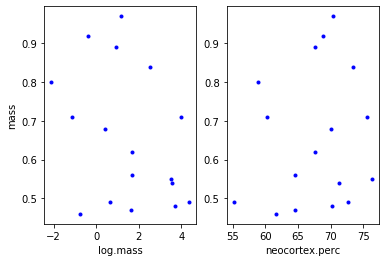

In [3]:
# Load milk data
df_milk = pd.read_csv('/home/amit/AmitKushwaha/Courses/Books/StatisticalRethinkingBook/Data/milk.csv',sep=';')
df_milk.dropna(inplace=True)

kcal_per_g = df_milk['kcal.per.g'].values
log_mass = np.log(df_milk['mass'].values)
neocortex_perc = df_milk['neocortex.perc'].values

fig,ax = plt.subplots(ncols=2)
ax[0].plot(log_mass,kcal_per_g,'b.')
ax[1].plot(neocortex_perc,kcal_per_g,'b.')
ax[0].set_xlabel('log.mass')
ax[1].set_xlabel('neocortex.perc')
ax[0].set_ylabel('mass')
plt.show()


In [4]:
# Model with single predictor 1
with pm.Model() as model_neocortex:
    a = pm.Normal('a', mu=0, sigma=100)
    bl = pm.Normal('bl', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bl*neocortex_perc)
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=kcal_per_g)
    trace_neocortex = pm.sample(cores=2)

# Model with single predictor 2
with pm.Model() as model_log_mass:
    a = pm.Normal('a', mu=0, sigma=100)
    br = pm.Normal('br', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + br*log_mass)
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=kcal_per_g)
    trace_log_mass = pm.sample(cores=2)

# Model with both predictors
with pm.Model() as model_neocortex_mass:
    a = pm.Normal('a', mu=10, sigma=10)
    bl = pm.Normal('bl', mu=0, sigma=1)
    br = pm.Normal('br', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bl*neocortex_perc + br*log_mass)
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=kcal_per_g)
    trace_neocortex_mass = pm.sample(cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:11<00:00, 178.83draws/s]
The acceptance probability does not match the target. It is 0.8789535549546118, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794998053357892, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 876.41draws/s]
The acceptance probability does not match the target. It is 0.8794724016148564, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multipro

(<Figure size 432x705.6 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ffaf22650>],
       dtype=object))

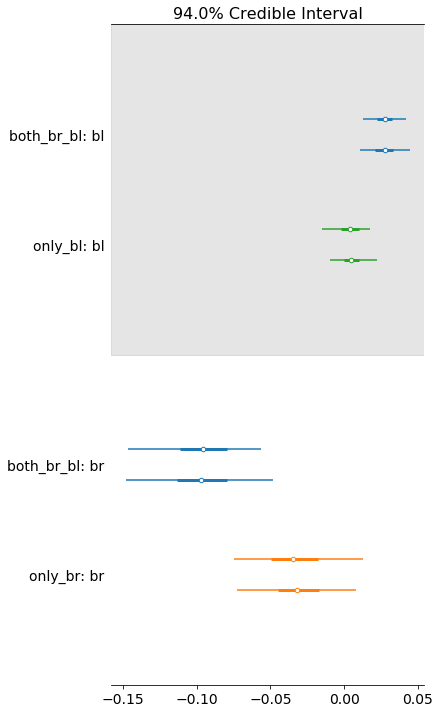

In [5]:
# Plots
az.plot_forest([trace_neocortex_mass, trace_log_mass, trace_neocortex], 
model_names=['both_br_bl', 'only_br','only_bl'],
var_names=['bl','br'])


Text(0, 0.5, 'kcal.per.g')

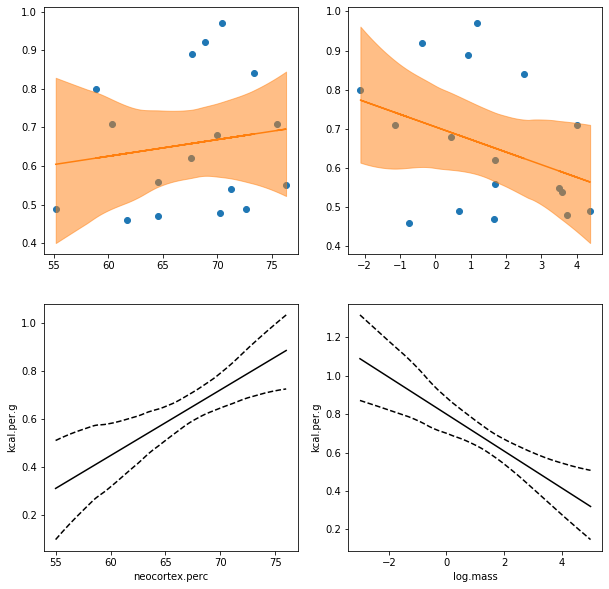

In [6]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(10,10))

mu_mean = trace_neocortex['mu']
ax[0,0].scatter(neocortex_perc,kcal_per_g)
ax[0,0].plot(neocortex_perc, mu_mean.mean(0), 'C1')
az.plot_hpd(neocortex_perc, mu_mean,ax=ax[0,0])

mu_mean = trace_log_mass['mu']
ax[0,1].scatter(log_mass,kcal_per_g)
ax[0,1].plot(log_mass, mu_mean.mean(0), 'C1')
az.plot_hpd(log_mass, mu_mean,ax=ax[0,1])

seq = np.linspace(55, 76, 50)
mu_pred = trace_neocortex_mass['a'] + trace_neocortex_mass['bl'] * seq[:,None] + trace_neocortex_mass['br'] * log_mass.mean()
ax[1,0].plot(seq, mu_pred.mean(1), 'k')
az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax[1,0])

ax[1,0].set_xlabel('neocortex.perc')
ax[1,0].set_ylabel('kcal.per.g')

seq = np.linspace(-3, 5, 50)
mu_pred = trace_neocortex_mass['a'] + trace_neocortex_mass['bl'] *neocortex_perc.mean() + trace_neocortex_mass['br'] *seq[:,None] 
ax[1,1].plot(seq, mu_pred.mean(1), 'k')
az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax[1,1])

ax[1,1].set_xlabel('log.mass')
ax[1,1].set_ylabel('kcal.per.g')

In [7]:
az.summary(trace_neocortex, ['a','bl','sigma'], credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.368,0.578,-0.457,1.347,0.033,0.025,304.0,272.0,317.0,210.0,1.00
bl,0.004,0.009,-0.010,0.017,0.000,0.000,303.0,246.0,315.0,214.0,1.00
sigma,0.196,0.040,0.136,0.250,0.002,0.002,339.0,327.0,373.0,347.0,1.01
